In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
# from neuralhydrology.utils.config import Config
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from model_utils import *
import pickle
import cartopy.crs as ccrs
import cartopy.feature as cf
import os
import geopandas as gpd
import glob
import matplotlib.gridspec as gridspec

In [2]:
# import os
# ruta_base = os.getcwd()
# os.chdir('../1_Pretratamiento/')
# from metricas_rendimiento import KGE, KGEmod, ECDF
# os.chdir('../3_NeuralHydrology/')

## Configuración

In [3]:
# with open("config.yml", "r", encoding='utf8') as ymlfile:
#     cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

# # ruta donde se ubican los datos del Anurio de Aforos
# path_anuario = Path('../../data/anuario_aforos/')
# path_caravan = Path(cfg['rutas'].get('caravan', '../../data/caravan/'))

# # inicio y fin del periodo de estudio
# start = cfg['periodo'].get('inicio', None)
# end = cfg['periodo'].get('final', None)
# start, end = [pd.to_datetime(i) for i in [start, end]]

# # tamaño de las muestras de entrenamiento y validación
# train_size = cfg.get('train_size', .6)
# assert 0 < train_size <= 1., '"train_size" debe de ser un valor entre 0 y 1'
# val_size = cfg.get('val_size', .2)
# assert 0 < val_size <= 1., '"train_size" debe de ser un valor entre 0 y 1'
# if train_size + val_size > 1:
#     val_size = 1 - train_size
#     print(f'El valor de "val_size" fue truncado a {val_size:.2f}')
# seed = cfg.get('seed', 0)

In [4]:
path_anuario = Path('../../data/anuario_aforos/')
path_camels = Path('../../data/CAMELS-ES/')

### Estaciones

In [5]:
# cargar estaciones
shapefile = glob.glob(f'{path_anuario}/GIS/estaciones*.shp')[0]
estaciones = gpd.read_file(shapefile)
estaciones.set_index('indroea', drop=True, inplace=True)
# estaciones.index = estaciones.index.astype(int)

# recortar estaciones a las utilizadas en CAMELS-ES
all_basins = pd.read_csv(path_camels / 'basins_all.txt', header=None).squeeze().values.astype(str)
estaciones = estaciones.loc[all_basins,:]

# definir qué estaciones se usan en el entrenamiento, validación y test
for period in ['train', 'validation', 'test']:
    sample = pd.read_csv(path_camels / f'basins_{period}.txt', header=None).squeeze().values.astype(str)
    estaciones[period] = 0
    estaciones.loc[sample, period] = 1

print(f'nº de estaciones:\t{estaciones.shape[0]}')
estaciones.head()

nº de estaciones:	1074


,lugar,comentario,serv,suprest,suprcnc,hoja_id,alti,altimax,naa,naam,...,cod_saih,cuenca,caudal,ini_cal,fin_cal,sel,geometry,train,validation,test
indroea,,,,,,,,,,,,,,,,,,,,,
1034,PUENTE DE LAS SEGADAS,INT 1941,0,663,4866,52,129.0,NaN,20,31,...,NaN,CANTABRICO,0,NaN,NaN,0,POINT (-5.86433 43.30727),0,0,1
1040,FORNO,INT 1920,0,1657,4866,28,80.0,NaN,8,8,...,NaN,CANTABRICO,0,NaN,NaN,0,POINT (-5.96580 43.34887),0,1,0
1042,TRUBIA,INT 1919,0,2530,4866,28,60.0,NaN,8,8,...,NaN,CANTABRICO,0,NaN,NaN,0,POINT (-5.97602 43.38647),1,0,0
1043,SAN PEDRO DE NORA,INT 1952,0,372,382,28,78.0,NaN,27,35,...,NaN,CANTABRICO,0,NaN,NaN,0,POINT (-5.96090 43.36971),0,0,1
1050,PUENTE DE LA FLORIDA,INT 1934,0,1011,1850,51,220.0,NaN,17,21,...,NaN,CANTABRICO,0,NaN,NaN,0,POINT (-6.42143 43.29593),1,0,0


### Simulación

In [6]:
experiment = 'CAMELS-ESP'
path = Path(experiment)
run_dir = path / 'runs' / 'CAMELS-ES_end_1609_131613'

In [7]:
# cfg = Config(path / 'config2_end.yml')
epochs = 50 #cfg.epochs
metric = 'KGE' #cfg.metrics[0]

In [8]:
results = {}
metrics = {period: pd.DataFrame(columns=range(1, epochs + 1)) for period in ['train', 'validation', 'test']}
for period, df in metrics.items():
    for epoch in df.columns:
        try:
            results_, df[epoch] = get_results(run_dir, period, epoch=epoch)
        except:
            continue

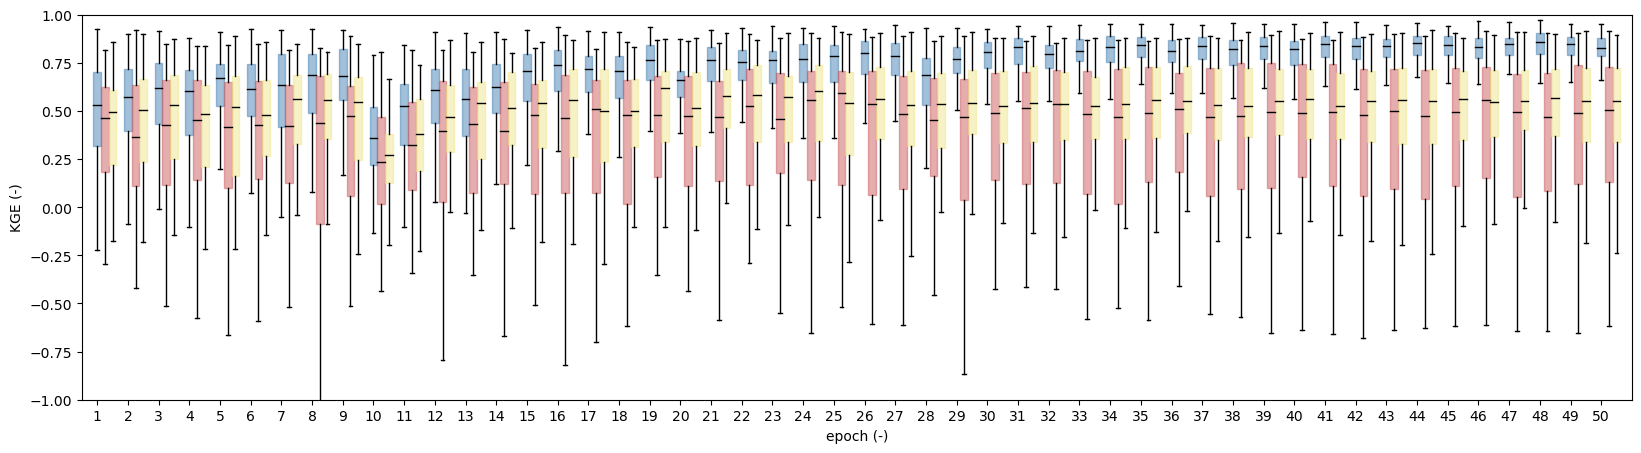

In [9]:
fig, ax = plt.subplots(figsize=(20, 5))

colors = ['steelblue', 'indianred', 'khaki']
for i, ((period, df), c) in enumerate(zip(metrics.items(), colors)):
    bp = ax.boxplot(df, positions=df.columns + i * .25, widths=0.25,
                    patch_artist=True,
                    boxprops={'color': c, 'alpha': .5},
                    # whiskerprops={},
                    showfliers=False,
                    medianprops={'color': 'k'})
    for box in bp['boxes']:
        box.set_facecolor(c)

ax.set_ylim(-1, 1);
xticks = np.linspace(1, epochs, num=epochs).astype(int)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.set(xlabel='epoch (-)',
       ylabel=f'{metric} (-)');

In [10]:
best_epoch = {}
for period, df in metrics.items():
    epoch = df.median().idxmax()
    best_epoch[period] = epoch
    print('epoch {0:>2}:\tKGEtrain = {1:.3f}   KGEval = {2:.3f}   KGEtest = {3:.3f}'.format(epoch,
                                                                                         metrics['train'][epoch].median(),
                                                                                         metrics['validation'][epoch].median(),
                                                                                         metrics['test'][epoch].median()))

epoch 48:	KGEtrain = 0.861   KGEval = 0.471   KGEtest = 0.568
epoch 25:	KGEtrain = 0.784   KGEval = 0.591   KGEtest = 0.544
epoch 19:	KGEtrain = 0.764   KGEval = 0.481   KGEtest = 0.621


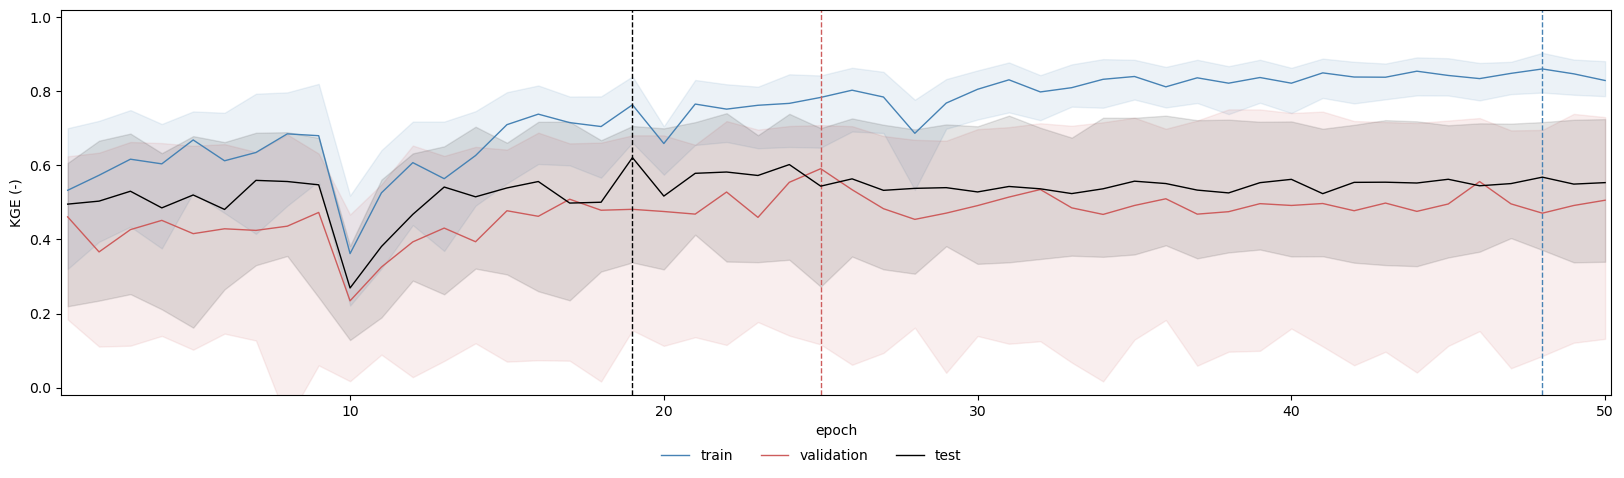

In [11]:
fig, ax = plt.subplots(figsize=(20, 5))

colors = ['steelblue', 'indianred', 'k']
for (period, df), c in zip(metrics.items(), colors):
    aux = df.quantile([.25, .5, .75])
    ax.plot(aux.loc[.5], c=c, lw=1, label=period)
    ax.axvline(best_epoch[period], lw=1, ls='--', c=c)
    ax.fill_between(aux.columns, aux.loc[.25], aux.loc[.75], color=c, alpha=.1)
ax.set(xlabel='epoch',
       xlim=(1 - .2, epochs + .2),
       ylabel='KGE (-)',
       ylim=(-.02, 1.02));
fig.legend(frameon=False, loc=8, ncol=3, bbox_to_anchor=[.3, -0.05, .4, .05]);

In [12]:
for period, df in metrics.items():
    print(period, df.shape[0])

train 163
validation 53
test 53


In [13]:
# extraer KGE de la mejor época
epoch = best_epoch['validation']

kge = pd.concat((metrics['train'][epoch], metrics['validation'][epoch], metrics['test'][epoch]), axis=0)
kge.name = 'KGE'
kge.index = kge.index.astype(str)

In [15]:
# añadir rendimiento en el shapefile de estaciones
estaciones = estaciones.loc[kge.index]
estaciones['KGE'] = kge

In [17]:
# export shapefile
estaciones.to_file(f'{experiment}_KGE.shp', index=True)